In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize #PuLP was not a good fit as the problem is not linear
np.random.seed(0)

In [2]:
sp500_returns = pd.read_csv('../Data/SP500_compounded_return.csv').set_index('Ticker') #for easier indexing
covariance_df = pd.read_csv('../Data/SP500_mean_return_covariance.csv')
tickers = pd.read_csv('../Data/SP500_compounded_return.csv')['Ticker']

#New dataset to get risk-free rate, taken from https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2018
#Using the federal funds effective rate dataset was producing strange results
daily_treasury_rates = pd.read_csv('../Data/daily-treasury-rates.csv').set_index('Date')

num_tickers = len(tickers)
rf = daily_treasury_rates['5 Yr']['01/31/2018']/100 #% yield of a 5-year bond

In [3]:
def objective(x, mean_returns, covariance, rf):
    numerator = np.matmul(np.array(mean_returns), x.T) - rf
    denominator = np.sqrt(np.matmul(x.T, np.matmul(covariance, x)))
    return -(numerator/denominator) #using a minimization solver, therefore set to negative to find maximum Sharpe ratio

#Constrains sum of all weights to be equal to 1
def constraint_sum_1(x):
    A = np.ones(x.shape)
    b = 1
    constraintVal = np.dot(A, x.T) - b
    return constraintVal

x_init = np.repeat(1/num_tickers, num_tickers) #initial vector of equally weighted stocks
constraints = ({'type':'eq', 'fun':constraint_sum_1})
lower = 0 #Change this if you want nonzero weights; most weights are nonzero already but are exceptionally small
upper = 1
bounds = tuple([(lower, upper) for x in x_init])
opt = optimize.minimize(
    objective, 
    x0=x_init, 
    args=(sp500_returns['Average Return'], np.array(covariance_df),rf),
    bounds = bounds,
    constraints = constraints,
    tol = 10**-3
)

In [4]:
optimized_weights = pd.DataFrame(data=np.round(opt.x*100,6), index=tickers, columns=['Stock Weight %'])
optimized_weights.to_csv('../Data/weight_vector.csv', index=False)
#Top 10 stocks; picture for report
optimized_weights.sort_values(by='Stock Weight %',ascending=False).head(10)

,Stock Weight %
Ticker,
NVDA,35.773129
STZ,30.228812
FB,13.811315
CNC,9.176033
NFLX,6.310404
LUV,3.226672
AVGO,1.473636
NUE,0.000000
NTRS,0.000000


In [5]:
def get_annual_adjusted_average_return(weights, arr_return, rf):
    return (np.matmul(np.array(arr_return), weights.T) - rf) * 12
def get_annual_volatility(weights, cov_return):
    return np.sqrt(np.matmul(weights.T, np.matmul(np.array(cov_return), weights))) * (12**0.5)

optimal_adj_avg_return = get_annual_adjusted_average_return(opt.x, sp500_returns['Average Return'], rf)#(np.matmul(np.array(sp500_returns['Average Return']), opt.x.T) - rf)
optimal_risk = get_annual_volatility(opt.x, covariance_df)#np.sqrt(np.matmul(opt.x.T, np.matmul(np.array(covariance_df), opt.x)))
optimal_sharpe_ratio = (optimal_adj_avg_return) / optimal_risk #multiply by (12/sqrt of 12) to convert monthly to yearly
print(f'Annualized Risk-Adjusted Average Return of Optimal Portfolio: {optimal_adj_avg_return}')
print(f'Annualized Volatility of Optimal Portfolio: {optimal_risk}')
print(f'Annualized Optimal Sharpe Ratio: {optimal_sharpe_ratio}')

Annualized Risk-Adjusted Average Return of Optimal Portfolio: 0.18877736759825897
Annualized Volatility of Optimal Portfolio: 0.1500469890479244
Annualized Optimal Sharpe Ratio: 1.2581216643938402


In [15]:
#Only use stocks which have a nonzero optimal weight for constructing random portfolios.
#Otherwise, the chance of generating a useful portfolio is exceedingly small due to how many tickers there are.
important_indices = optimized_weights.sort_values(by='Stock Weight %',ascending=False).loc[optimized_weights['Stock Weight %'] != 0].index
indices = [np.where(optimized_weights.index == i)[0][0] for i in np.array(important_indices)]

#Generate random portfolios
n_portfolios = 10000
returns = np.zeros(n_portfolios)
risk = np.zeros(n_portfolios)
for i in range (0, n_portfolios):
    random_weight = np.zeros(num_tickers)#np.random.dirichlet(np.ones(num_tickers))
    #Randomizing indices of the random portfolios has a very high likelihood of producing a weak portfolio.
    #indices = np.random.randint(0, num_tickers, 7)
    for j in indices:
        random_weight[j] = np.random.random(1)[0]
    random_weight /= sum(random_weight)
    returns[i] = get_annual_adjusted_average_return(random_weight, sp500_returns['Average Return'], rf)
    risk[i] = get_annual_volatility(random_weight, covariance_df)
sharpe = returns/risk

Largest Random Sharpe Ratio: 0.5026
Optimal Portfolio Sharpe Ratio: 1.2581


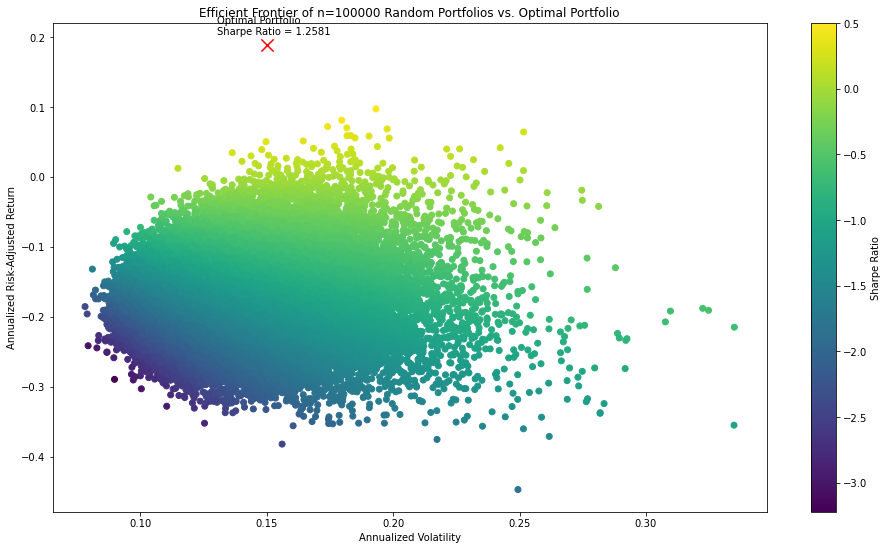

In [16]:
print(f'Largest Random Sharpe Ratio: {round(sharpe.max(), 4)}')
print(f'Optimal Portfolio Sharpe Ratio: {round(optimal_sharpe_ratio, 4)}')
#
plt.figure(figsize=(16, 9))
plt.scatter(x=risk, y=returns,c=sharpe,cmap='viridis')
colorbar = plt.colorbar()
colorbar.set_label('Sharpe Ratio')
#plt.scatter(x=risk[np.argmax(sharpe)],y=returns[np.argmax(sharpe)], marker='x', color='blue', s=100)
plt.annotate(f'Optimal Portfolio\nSharpe Ratio = {round(optimal_sharpe_ratio, 4)}',
            xy=(optimal_risk,optimal_adj_avg_return),
            xycoords='data',
            xytext=(-50, 10),
            textcoords='offset points'
)
plt.scatter(x=optimal_risk,y=optimal_adj_avg_return, marker='x', color='red', s=150)
plt.title(f'Efficient Frontier of n={n_portfolios} Random Portfolios vs. Optimal Portfolio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Risk-Adjusted Return')
plt.savefig('../Visualizations/efficient_frontier.png')
plt.show()